### Code used in Chapter 4: DFT Numerics

Import some important libraries. Most Python distributions do not come with pyFFTW, might need to pip install pyfftw.

In [2]:
import numpy as np
import numexpr as ne
import matplotlib.pyplot as plt
from scipy import integrate
import time
import pyfftw
import h5py
import os
from numba import jit
%matplotlib inline

Define functions for central difference based on the 4th-order isotropic central difference stencil.
<img src="grid.png" alt="central difference grid" style="width: 500px;"/>

Function `shift` gets the stencil values around each $(m,n)$ and stores them in an intermediate array. These intermediate arrays are multiplied by the corresponding weights in function `centralDiffNumexpr` (`centralDiffShift` is a non-numexpr equivalent).

In [3]:
@jit(nopython=True)
def shift(A,num):
    E = np.empty_like(A)
    F = np.empty_like(A)
    G = np.empty_like(A)
    H = np.empty_like(A)
    
    E[:num] = A[-num:]
    E[num:] = A[:-num]
    F[:-num] = A[num:]
    F[-num:] = A[:num]
    
    G[:,:num] = A[:,-num:]
    G[:,num:] = A[:,:-num]
    H[:,:-num] = A[:,num:]
    H[:,-num:] = A[:,:num]
    return E + F + G + H

@jit(nopython=True)
def centralDiffShift(A,h,Nx):
    A = A**3
#     D = np.empty_like((Nx,Nx))
    D = -1.*shift(A,2)+ 16.*shift(A,1) - 60.*A
    return D/(12.*h**2)

# def centralDiffNumexpr(A,h,Nx):
#     A = ne.evaluate('A**3')
#     F = shift(A,2)
#     E = shift(A,1)
#     D = np.empty_like(A)
#     D = ne.evaluate('(-1.*F + 16.*E - 60.*A) / (12.*h**2)')
#     return D

class writer(object):
    
    def __init__(self,prefix,chiN,eps,sigma):
        self.prefix = prefix
        self.chiN = chiN
        self.eps = eps
        self.sigma = sigma
        
        self.path = self.get_file_path()

        self.groups = ['avg_conc', 'energy', 'order_parameter']
        
        
    def get_file_path(self):
        base_output_folder = "./output"
        base_output_name = "/%s_chiN=%.2f_eps=%.4f_sigma=%.4f" %(self.prefix,self.chiN,self.eps,self.sigma)
        hdf5_format = '.h5'
        return base_output_folder + base_output_name + hdf5_format
        
        
    def create_output_file(self, options):
        print(self.path)

        if os.path.exists(self.path):
            os.rename(self.path, self.path+'_old')

        file = h5py.File(self.path, 'a')

        for group in self.groups:
            # check if groups have been created
            # if not created, create empty groups
            if not (group in file):
                file.create_group(group,track_order=True)

        for key in options:
            if type(options[key]) != str:
                file.attrs.create(key,options[key])
        file.close()
        
    def write_data(self, it, data):
        file = h5py.File(self.path , 'r+')
        
        for group, datum in zip(self.groups,data):
            name = group + '_%i' %it
            if isinstance(datum, (list, tuple, np.ndarray)):
                file.create_dataset(group + '/' + name, data=datum ,chunks=True, compression='gzip', compression_opts=4, dtype=np.float32)
            else:
                file.create_dataset(group + '/' + name, data=datum , dtype=np.float32)
        # print("writing time = %.1f for arrays %s" %(name,path))
        file.close()
        
    def get_dataset(self,group,it):
        file = h5py.File(self.path, 'r')
        
        arr = np.copy(file[group][group + '_' + str(it)])
        
        file.close()
        return arr
        

Initialise wisdom to None for pyFFTW.

In [4]:
wisdom = None

The main looping consisting of the Strang-Splitting involving:

    Substep 1: Fourier-PS (eqn 4.5a)
    Substep 2: Strong Stability Preserving 3rd-order Runge Kutta + 4th-order central finite difference scheme (eqn 4.5b)
    Substep 3: Fourier-PS (eqn 4.5c)

Energy is calculated from the free energy functional (eqn 1.1a), and the average concentration from (eqn 1.1b).

In [5]:
def dft(options, wisdom=None):
    L = options['L']
    Nx = options['Nx']
    eps = options['eps']
    sigma = options['sigma']
    m = options['m']
    dt = options['dt']
    it = options['it']
    chiN = options['chiN']
    prefix= options['prefix']
    
    io = writer(prefix,chiN,eps,sigma)
    io.create_output_file(options)
    
    h = L/Nx
    dx = np.linspace(0,L,Nx)
    
    # lv defines the levels for which sampling of the systems are made, e.g. sampling of energy and average concentration.
    lv = int(it/100)

    # define seed and uniform distribution.
    # seed = 693
    # np.random.seed(seed)
    r = np.random.uniform(-1.,1.,(Nx,Nx))

    # zeroing the mean of the uniform distribution.
    if r.mean()<0:
        r -= r.mean()
    else:
        r += r.mean()

    # a scaling factor
    C = 0.01

    # a constant
    tpiL = 2.*np.pi/L

    # initialise arrays for pyFFTW.
    u = pyfftw.empty_aligned((Nx,Nx), dtype='complex128', n=16)
    v = pyfftw.empty_aligned((Nx,Nx), dtype='complex128', n=16)
    vp = pyfftw.empty_aligned((Nx,Nx), dtype='complex128', n=16)
    vpp = pyfftw.empty_aligned((Nx,Nx), dtype='complex128', n=16)

    # define initial conditions.
    u[:,:] = m + C*r

    # get wavenumber/frequency grids (k2 == k^2; k4 == k^4)
    freqs = np.fft.fftfreq(Nx,(1.0/float(Nx)))
    kx, ky = np.meshgrid(freqs,freqs)
    k = kx + ky
    k2 = kx**2+ky**2
    k4 = k2**2
    k = np.sqrt(k2)

    # initialise arrays to store avg. concentration and energy values.
    avgConc = np.zeros(int(it/lv+1))
    energy = np.zeros(int(it/lv+1))

    # if there is wisdom for FFT plans, import it.
    if wisdom != None:
        pyfftw.import_wisdom(wisdom)

    # define pyFFTW plans for the forward and inverse FFTs.
    fft_object = pyfftw.FFTW(u, vpp, threads=4, axes=(0,1))
    ifft_object = pyfftw.FFTW(vpp, v, direction='FFTW_BACKWARD', threads=4, axes=(0,1))

    fft_object = pyfftw.FFTW(v, vp, threads=4, axes=(0,1))
    ifft_object = pyfftw.FFTW(vp, u, direction='FFTW_BACKWARD', threads=4, axes=(0,1))

    # initialise some counters.
    j = 0
    t1 = 0
    t2 = 0
    t3 = 0

    for i in range(it+1):
        # the first Strang-splitting substep (eqn 4.5a): Fourier-PS.
        tic1 = time.time()
        vpp = np.exp(0.5*(-1.*eps**2*k4*tpiL**4+k2*tpiL**2-sigma)*dt)*fft_object(u)
        v = ifft_object(vpp).real
        toc1 = time.time()
        t1 += (toc1-tic1)

        # the second Strang-splitting substep (eqn 4.5b): SSP-RK3.
        tic2 = time.time()
        Fu = centralDiffShift(v,h,Nx)
        v1 = ne.evaluate('v + dt * (Fu + sigma*m)')
        Fu = centralDiffShift(v1,h,Nx)
        v2 = ne.evaluate('3./4. * v + 1./4. * v1 + 1./4. * dt * (Fu + sigma*m)')
        Fu = centralDiffShift(v2,h,Nx)
        v = ne.evaluate('1./3. * v + 2./3. * v2 + 2./3. * dt * (Fu + sigma*m)')
        toc2 = time.time()
        t2 += (toc2-tic2)

        # the third Strang-splitting substep (eqn 4.5c): Fourier-PS.
        tic3 = time.time()
        vp = np.exp(0.5*(-1.*eps**2*k4*tpiL**4+k2*tpiL**2-sigma)*dt)*fft_object(v)
        u = ifft_object(vp).real
        toc3 = time.time()
        t3 += (toc3-tic3)

        # plot intermediate morphologies.
    #     if i%int((it-1)/10)==0:
    #         fig1 = plt.figure(figsize=(3,3))
    #         plt.imshow(u,origin='left', extent=[0,L,0,L])

        # sample energy and average concentration at levels.
        if i%lv==0:
            dim = 2
            u0 = u

            # get average concentration.
            for d in range(dim):
                u0 = integrate.trapz(u0,dx)
                
            avg_conc = u0 / L**2
            avgConc[j] = avg_conc

            # get energy.
            T1 = -1.j * k * tpiL * np.fft.fft2(u)
            T1 = np.real(np.fft.ifft2(T1))
            T1 = 0.5*eps**2*abs(T1)**2

            T2 = 1./4*(np.real(u)**2-1.)**2

            up = np.real(u)-m
            for d in range(dim):
                up = integrate.trapz(up,dx)
            T3 = -1.*up
            T3 = 0.5*sigma*abs(T3)**2

            en = T1 + T2 + T3
            en = np.real(en)
            for d in range(dim):
                en = integrate.trapz(en,dx)
            energy[j] = en
            j += 1
            
#             print("writing output at i = %i" %i)
            data = [avg_conc, en, u]
            io.write_data(i, data)
        
        if it % 1000 == 0:
            print("iteration = %i" %it)

    return pyfftw.export_wisdom()

# normalise against initial energy. Possible since energy is unitless.
# energy /= energy[0]

# save array outputs
# np.savetxt('uArray-dt=%s,it=%s,Nx=%s,sigma=%s,m=%s,seed=%s.txt' %(dt,it,Nx,sigma,m,seed), u)
# np.savetxt('energy-dt=%s,it=%s,Nx=%s,sigma=%s,m=%s,seed=%s.txt' %(dt,it,Nx,sigma,m,seed), energy)
# np.savetxt('avgConc-dt=%s,it=%s,Nx=%s,sigma=%s,m=%s,seed=%s.txt' %(dt,it,Nx,sigma,m,seed), avgConc)

# print time taken.
# print("time taken1: %.2f" %(t1))
# print("time taken2: %.2f" %(t2))
# print("time taken3: %.2f" %(t3))
# print("total time taken: %.2f" %(t1+t2+t3))

# # plot final figure.
# fig = plt.figure(figsize=(3,3))
# plt.imshow(u,origin='left', extent=[0,L,0,L])
# plt.colorbar()
# plt.show()

In [17]:
# L = length of domain; Nx = spatial resolution;
# h = spatial stepsize; dx = 1D spatial grid;
# dt = temporal stepsize
L = 2.*np.pi
L = 1.0
Nx = 128
dt = 0.0005

# define small parameters.
eps = 0.08
sigma = 5.0

# L = 6.0
chiN = 20.0
N = 20
l = 1./N
f = 1.-0.3
chi = chiN / N
omega = (L**2)**(2/3)
# omega = 1.0

# eps2 = l**2 / (3. * f * (1. - f) * chi * omega)
# eps = np.sqrt(eps2)

# sigma = 36. * omega / (1. * N**2 * l**2 * f**2 * (1.-f)**2 * chi)

# print(eps2)
print(eps)
print(sigma)
print(chiN)

# u-bar == m.
m = 0.0

# number of iterations
it = 10000
it += 1

options = {
    'L' : L,
    'Nx' : Nx,
    'eps' : eps,
    'sigma' : sigma,
    'm' : m,
    'dt' : dt,
    'it' : it,
    'prefix' : 'dft',
    'N' : N,
    'l' : l,
    'f' : f,
    'chi' : chi,
    'chiN' : chiN,
    'omega' : omega
}

0.08
5.0
20.0


In [18]:
iwisdom = dft(options)

./output/dft_chiN=20.00_eps=0.0800_sigma=5.0000.h5


[array(0.24999997, dtype=float32), array(0.2499999, dtype=float32), array(0.24999776, dtype=float32), array(0.24993956, dtype=float32), array(0.24829315, dtype=float32), array(0.21716946, dtype=float32), array(0.1530988, dtype=float32), array(0.13617572, dtype=float32), array(0.1334275, dtype=float32), array(0.13309368, dtype=float32), array(0.1330296, dtype=float32), array(0.13299419, dtype=float32), array(0.13296665, dtype=float32), array(0.13294499, dtype=float32), array(0.13292821, dtype=float32), array(0.13291538, dtype=float32), array(0.13290565, dtype=float32), array(0.13289836, dtype=float32), array(0.13289295, dtype=float32), array(0.132889, dtype=float32), array(0.13288616, dtype=float32), array(0.13288414, dtype=float32), array(0.13288277, dtype=float32), array(0.13288188, dtype=float32), array(0.13288134, dtype=float32), array(0.13288108, dtype=float32), array(0.13288099, dtype=float32), array(0.13288103, dtype=float32), array(0.13288116, dtype=float32), array(0.13288136, d

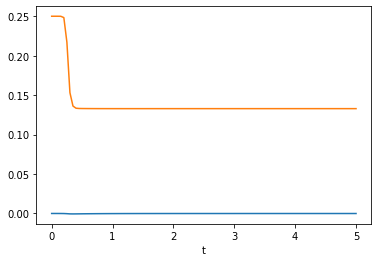

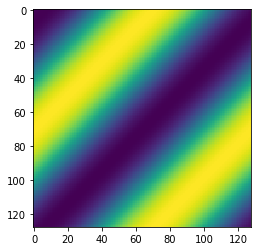

In [19]:


prefix = options['prefix']
chiN = options['chiN']
eps = options['eps']
sigma = options['sigma']
it = options['it']
dt = options['dt']

lv = int(it/100)
         
io = writer(prefix,chiN,eps,sigma)
its = np.arange(0,it,lv)


t = np.arange(0,it/lv)*dt*lv

# arr = io.get_dataset('energy', 1000)
# print(arr)

energy = []
for it in its:
    arr = io.get_dataset('energy',it)
    energy.append(arr)
    
avg_conc = []
for it in its:
    arr = io.get_dataset('avg_conc',it)
    avg_conc.append(arr)
    
print(energy)
    
fig2 = plt.figure()
plt.xlabel('t')
plt.plot(t,avg_conc)
plt.plot(t,energy)
# plt.ylim([0,1])
plt.show()

order_param = io.get_dataset('order_parameter',options['it']-1)
fig = plt.figure()
plt.imshow(order_param)
plt.show()